<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 499, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 499 (delta 30), reused 30 (delta 13), pack-reused 443 (from 1)
Receiving objects: 100% (499/499), 3.31 MiB | 20.04 MiB/s, done.
Resolving deltas: 100% (311/311), done.


In [2]:
from kltn.init.install_dependencies import install_packages
install_packages("./kltn")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from monai.metrics import DiceMetric

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax
from kltn.models import unet3d, unet3d_cot, unet3d_cot_da, unet3d_rescot_da
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
log_path = "/content/drive/MyDrive/KLTN/logs"
source_folder = '/content/LITS17'
LOGGER = init_logger(log_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=source_folder)

## Load data

In [6]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=source_folder, seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

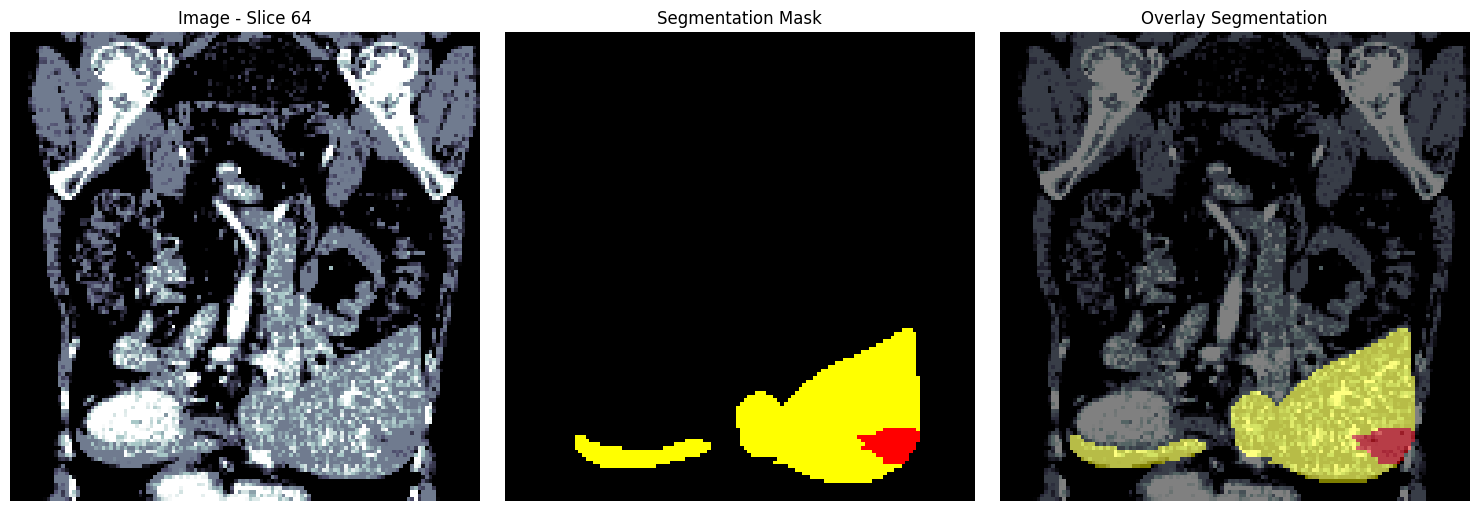

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    slice_idx = image_sample.shape[2] // 2

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, 0, slice_idx, :, :].numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")


    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")


    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break

## Model

In [9]:
model = unet3d.UNet3D(in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [10]:
start_epoch = 1
max_epochs = 1 # 100
batch_size = 1 # 2
val_every = 1

criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
path_save_model = "/content/drive/MyDrive/KLTN/code/weight"

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, best_epoch, dices_liver, dices_tumor, dices_avg, loss_epochs, trains_epoch
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    scheduler = scheduler,
    batch_size = batch_size,
    max_epochs = max_epochs,
    start_epoch = start_epoch,
    val_every = val_every,
    path_save_model = path_save_model,
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/1 1/105 loss: 0.7693 time 10.39s
Epoch 1/1 2/105 loss: 0.7047 time 0.68s
Epoch 1/1 3/105 loss: 0.6650 time 10.70s
Epoch 1/1 4/105 loss: 0.6435 time 5.67s
Epoch 1/1 5/105 loss: 0.6327 time 12.66s
Epoch 1/1 6/105 loss: 0.6225 time 11.03s
Epoch 1/1 7/105 loss: 0.6147 time 10.77s
Epoch 1/1 8/105 loss: 0.6081 time 5.02s
Epoch 1/1 9/105 loss: 0.6022 time 8.04s
Epoch 1/1 10/105 loss: 0.5972 time 5.18s
Epoch 1/1 11/105 loss: 0.5928 time 2.15s
Epoch 1/1 12/105 loss: 0.5887 time 1.00s
Epoch 1/1 13/105 loss: 0.5851 time 9.30s
Epoch 1/1 14/105 loss: 0.5821 time 11.44s
Epoch 1/1 15/105 loss: 0.5790 time 2.16s
Epoch 1/1 16/105 loss: 0.5765 time 4.54s
Epoch 1/1 17/105 loss: 0.5742 time 4.63s
Epoch 1/1 18/105 loss: 0.5720 time 2.40s
Epoch 1/1 19/105 loss: 0.5696 time 4.79s
Epoch 1/1 20/105 loss: 0.5667 time 0.91s
Epoch 1/1 21/105 loss: 0.5647 time 14.14s
Epoch 1/1 22/105 loss: 0.5623 time 2.03s
Epoch 1/1 23/105 loss: 0.5605 time 9.10s
Epoch 1/1 24/105 loss: 0.5589 time 5.34s
Epoch 1/1 25/105 l

Final training epochs: 1/1 ---[loss: 0.4663] ---[time 594.67s]
INFO:kltn.utils.logger:Final training epochs: 1/1 ---[loss: 0.4663] ---[time 594.67s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/1 105/105 loss: 0.4663 time 5.57s


/content/kltn/utils/metrics.py:157: RuntimeWarning: invalid value encountered in divide
  self.avg = self.sum / self.count
Val 1/1 1/26, Dice_Liver: 0.363050, Dice_Tumor: nan, Dice_Avg: nan, time 11.18s
INFO:kltn.utils.logger:Val 1/1 1/26, Dice_Liver: 0.363050, Dice_Tumor: nan, Dice_Avg: nan, time 11.18s
Val 1/1 2/26, Dice_Liver: 0.444930, Dice_Tumor: 0.000000, Dice_Avg: 0.222465, time 8.31s
INFO:kltn.utils.logger:Val 1/1 2/26, Dice_Liver: 0.444930, Dice_Tumor: 0.000000, Dice_Avg: 0.222465, time 8.31s
Val 1/1 3/26, Dice_Liver: 0.418341, Dice_Tumor: 0.000000, Dice_Avg: 0.209170, time 6.53s
INFO:kltn.utils.logger:Val 1/1 3/26, Dice_Liver: 0.418341, Dice_Tumor: 0.000000, Dice_Avg: 0.209170, time 6.53s
Val 1/1 4/26, Dice_Liver: 0.405273, Dice_Tumor: 0.000000, Dice_Avg: 0.202636, time 2.42s
INFO:kltn.utils.logger:Val 1/1 4/26, Dice_Liver: 0.405273, Dice_Tumor: 0.000000, Dice_Avg: 0.202636, time 2.42s
Val 1/1 5/26, Dice_Liver: 0.362406, Dice_Tumor: 0.000000, Dice_Avg: 0.181203, time 4.29s
IN

New best (0.000000 --> 0.198987). At epoch 1


Training Finished !, Best Accuracy: 0.198987 --At epoch: 1 --Total_time: 766.26
INFO:kltn.utils.logger:Training Finished !, Best Accuracy: 0.198987 --At epoch: 1 --Total_time: 766.26


## Visualize Results

In [12]:
import glob
print(glob.glob(f"{path_save_model}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D_1.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


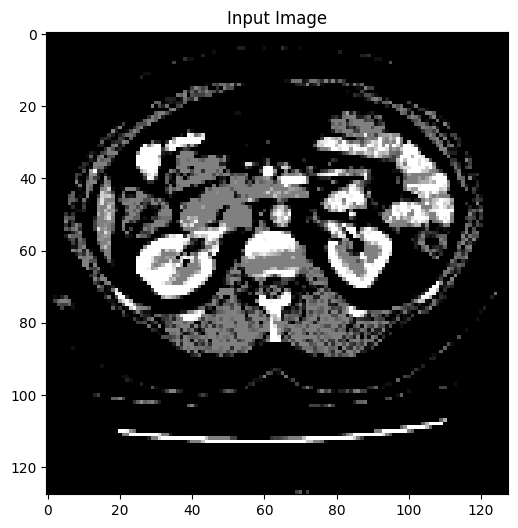

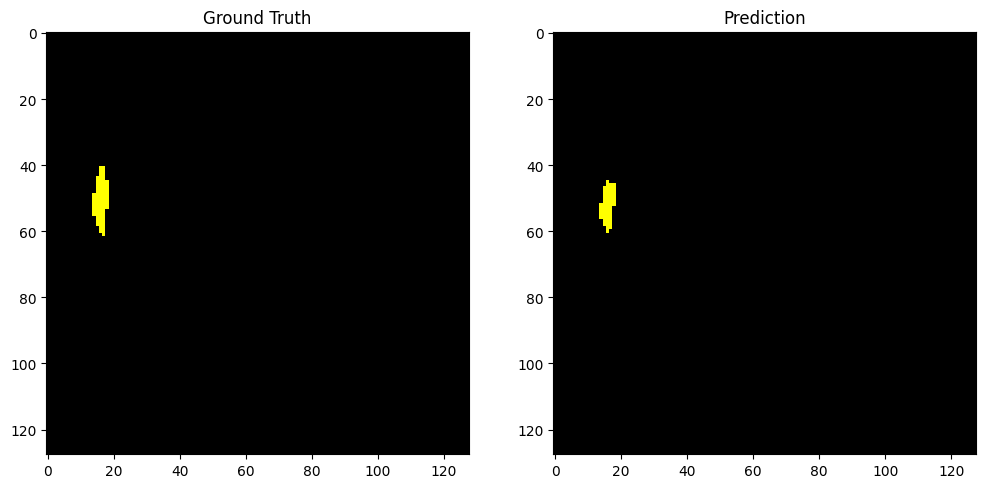

In [14]:
num_images = 1
# weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D_1.pth"
visualize_results(model, val_loader, weight_path, num_images, device)